# BTC NER dataset/ Named Entity Recognition 
#### NLP HW2  Due date: May 1
#### Team Member: B908108028 李子儀/  108810039 張洸銘

In [1]:
Topic = 'twitter-sentiment-analysi'
Author = ['Alice']
Author_token = ['S4O26v10RQusnWSTdQEK3QznlqvatkEUe1QXKbJZR8H']  ##

import time as ti
Date = ti.ctime()
Message = ''

In [1]:
import os
import codecs
from sklearn.model_selection import train_test_split

import utils

### write_new_split
    """ 
    Do stratified random sampling for a given corpus given by corpus_name,
    and save the results in file filename in directory filedir. Parameter
    test_size indicates the number of sentences to be used in the test set.

    For information on the parameter max_count, see the documentation for
    function stratified_split.

    For now, this only supports stratified_split at the sentence level.

    >>> TRAIN, TEST = write_new_split('CADEC', 1000, filedir, 'cadec', max_count = 2)
    >>> TRAIN, TEST = write_new_split('re3d', 200, filedir, 're3d', max_count = 2)
    >>> TRAIN, TEST = write_new_split('GUM', 1000, filedir, 'gum', max_count = 2)
    >>> TRAIN, TEST = write_new_split('MUC6', 1000, filedir, 'muc6', max_count = 2)
    >>> TRAIN, TEST = write_new_split('NIST_IEER99', 690, filedir, 'nist', max_count = 2)
    >>> TRAIN, TEST = write_new_split('BBN', 10000, filedir, 'bbn', max_count = 2)
    >>> TRAIN, TEST = write_new_split('GMB1', 1000, filedir, 'gmb1', max_count = 2)

    """

In [2]:
def write_new_split(corpus_name, test_size, filedir, filename,
                    seed = 42, max_count = 2):
    r = utils.read_conll(corpus_name)
    sentences = list(r)
    train_data, test_data = stratified_split(sentences,
                                             test_size,
                                             seed = seed,
                                             max_count = max_count)

    writefile(train_data, os.path.join(filedir,'train'), filename+'-train.conll')
    writefile(test_data, os.path.join(filedir,'test'), filename+'-test.conll')

    return train_data, test_data

### writefile
    """ 
    Write the sentences, in CONLL-format, to a file given by filename
    located in directory filedir.

    """

In [3]:
#TODO this should be moved to utils.
def writefile(sentences, filedir, filename, sep='\t'):
    DIR = filedir
    WRITEFILE = os.path.join(DIR, filename)
    if not os.path.exists(DIR):
            os.makedirs(DIR)
    if os.path.isfile(WRITEFILE):
        raise ValueError("The file already exists!")
    with codecs.open(WRITEFILE,'a+',encoding='utf-8') as fd:
        for sent in sentences:
            fd.write('\n')
            for tok in sent:
                fd.write(tok[0][0] + sep + tok[1]+'\n')

### stratified_split
    """
    Uses 'train_test_split' with stratification from scikit learn. However,
    since we want to split on the sentences level, we first map label
    occurrence statistics (only counting B- labels) to integer categories.
    
    max_count specifies the maximum label count we are interested in from
    the point of view of keeping the classes balanced. For example, say
    max_count = 2, the label set is [B-ADVERSE, B-DISEASE]. Then a sentence
    with 3 counts of B-ADVERSE and 2 counts of B-DISEASE is placed in the same
    bin as sentences with 2 counts of B-ADVERSE and 2 counts of B-DISEASE.

    If a bin only has one element, 'train_test_split' will fail, so in this
    event the element is mapped to the class of sentences with no labels.

    """

In [4]:
def stratified_split(sentences, test_size, max_count = 2, seed = 42):
    labels = [[iob for (x,iob) in d] for d in sentences]
    tags = list(set([i for s in labels for i in s if i[0]=='B']))
    inds = range(len(labels))

    Y = [_map_labels(l, tags, max_count) for l in labels]

    # Quick fix: if any element in Y only appears once, change it to 0
    ##################################################################
    if len(tags) < 20:
        maxnum = (max_count+1)**len(tags) - 1
        Yfreq = [Y.count(i) for i in range(maxnum+1)]
        fixcounts = [i for i,x in enumerate(Yfreq) if x==1]
        for c in fixcounts:
            Y[Y.index(c)] = 0
    else: # Due to memory issues:
        cc = [Y.count(Y[i]) for i in range(len(Y))]
        for i in range(len(cc)):
            if cc[i] == 1:
                Y[i] = 0
    ###################################################################

    inds_train, inds_test, Y_train, Y_test = train_test_split(inds, Y,
        test_size = test_size, random_state=seed, stratify=Y)

    train_data = [sentences[i] for i in inds_train]
    test_data = [sentences[i] for i in inds_test]

    return train_data, test_data

### check_label_ratios
    """ 
    This function can be used to compare the entity class proportions
    before and after the test/train split was made. tags is the set of
    entity class tags to compare.

    """

In [5]:
def check_label_ratios(train_data, test_data, orig_data, tags):
    train_tagcounts =  [ sum([len([i for i in T if i[1] == tag]) for T in train_data]) for tag in tags]
    test_tagcounts =  [ sum([len([i for i in T if i[1] == tag]) for T in test_data]) for tag in tags]
    orig_tagcounts =  [ sum([len([i for i in T if i[1] == tag]) for T in orig_data]) for tag in tags]

    train_ratios = [float(i)/sum(train_tagcounts) for i in train_tagcounts]
    test_ratios = [float(i)/sum(test_tagcounts) for i in test_tagcounts]
    orig_ratios = [float(i)/sum(orig_tagcounts) for i in orig_tagcounts]

    return train_ratios, test_ratios, orig_ratios

### _map_labels
    """
    Parameters
    ----------

    labels are the labels of one sentence

    tags : list
        Must all start with B-
    """

In [6]:
def _map_labels(labels, tags, max_count = 2):
    base = max_count + 1
    counts = [labels.count(t) for t in tags]
    # Any counts greater than max_count are put in the same 'bin' as max_count
    for i in range(len(counts)):
        if counts[i] > max_count:
            counts[i] = max_count

    Y = int("".join(map(str, counts)), base = base)
    return Y

In [7]:
from collections import Counter
import copy

### flatten

In [8]:
def flatten(sentences):
    """ Flatten a list.

    """
    f = [i for sublist in sentences for i in sublist]
    return f

### get_tagset

In [9]:
def get_tagset(sentences, with_prefix):
    """ Returns the set of entity types appearing in the list of sentences.

    If with_prefix is True, it returns both the B- and I- versions for each
    entity found. If False, it merges them (i.e., removes the prefix and only
    returns the entity type).

    """
    iobs = [iob for sent in sentences for (x,iob) in sent]
    tagset = set(iobs)
    if not with_prefix:
        tagset = set([t[2:] for t in list(tagset) if t != 'O'])
    return tagset

### get_IOB_counts

In [10]:
def c(sentences):
    """ Return a counter with IOB labels and their frequency.

    """
    types2 =[ j[1] for sublist in sentences for j in sublist] #list of IOBs
    ner_tags = Counter()

    for i,x in enumerate(types2):
        ner_tags[x] += 1

    return ner_tags

### get_word_counts

In [11]:
def get_word_counts(sentences, exclude_O = False):
    """ Return a Counter containing the number of times each word has appeared
    within the list of sentences.

    Parameters
    ----------

    sentences : list
        List of lists (sentences)

    exclude_O : bool
        If True, does not count words that have 'O' labels; that is, only
        words corresponding to entities will be counted.

    """
    f = flatten(sentences)

    if exclude_O:
        words = [x[0] for (x, iob) in f if iob != 'O']
    else:
        words = [x[0] for (x, iob) in f]

    word_count = Counter()
    for x in words:
        word_count[x] += 1

    return word_count

### remove_prefix

In [12]:
def remove_prefix(tok):
    if tok[:2] in {'B-', 'I-'}:
        tok = tok[2:]
    return tok

### sents_no_prefix

In [13]:
def sents_no_prefix(sents):
    newsents = copy.deepcopy(sents)
    s22 = [[ [list(x[0]),x[1]] for x in s] for s in newsents]
    fixed = [[ (tuple(x[0]), remove_prefix(x[1])) for x in s] for s in s22]
    return fixed

In [14]:
import codecs
import os
from collections import Counter
try:
    import ConfigParser
except:
    import configparser as ConfigParser

### get_entities

In [15]:
# import sentence_utils


# def get_entities(corpus_name):
#     """ Load the dataset from the filesystem corresponding to corpus_name
#     (to see the list of allowed names, use utils.list_corpora() ), and extract
#     all annotated entities.

#     Returns a dict, in which each key is an entity type, which contains a list
#     of entity mentions in the corpus.

#     """
#     r = read_conll(corpus_name); data = list(r)
#     data2 = [ [(w,iob) for ((w,p),iob) in d] for d in data]
#     data3 = [i for u in data2 for i in u]

#     tags = sentence_utils.get_tagset(data, with_prefix=True)
#     taglist = set([t[2:] for t in list(tags) if t !='O'])
#     entities = {}
#     for key in taglist:
#         entities[key] = []
#     data3.append((u'O',u'O'))
#     ent = []
#     entitytype = 'None'
#     for i,item in enumerate(data3[0:-1]):
#         if item[1] != 'O':
#             if item[1][0] == 'B':
#                 ent = []
#                 ent.append(item[0])
#             else: # == I
#                 if item[1][0] != 'I':
#                     raise ValueError("Should be I")
#                 ent.append(item[0])

#             if data3[i+1][1][2:] != item[1][2:] or data3[i+1][1][0] == 'B':
#                 #print i, item
#                 entitytype = item[1][2:]
#                 entities[entitytype].append(' '.join(ent))
#     return entities

### list_corpora

In [16]:
def list_corpora():
    """ List the available corpora names.

    These are read from file_locations.cfg. More corpus names can be added by
    editing this file.

    """
    config = ConfigParser.RawConfigParser()
    config.read('file_locations.cfg')
    return config.sections()

### get_corpus_location

In [17]:
def get_corpus_location(corpus_name):
    """ Given the corpus_name, this returns a tuple containing, in order:

    - file extension: only files with this file extension will be loaded
    - path to the directory in which the data resides.
    - path to the docs folder, containing both a human-readable summary of the
      dataset, and a machine-readable file indicating entity tagging sceme
      (IOB1, IOB2, etc), and information on which columns are used for tokens,
      entities, or POS tags.

    Parameter: corpus name (use function 'list_corpora' to view options.

    """
    config = ConfigParser.RawConfigParser()
    config.read('file_locations.cfg')
    xx = config.get(corpus_name, 'filename_end')
    xx = xx.split("\n")
    xx = tuple(xx)
    if len(xx)==1:
        xx = xx[0]

    filename_end = xx
    data_dir = config.get(corpus_name, 'data_dir')
    docs_dir = config.get(corpus_name, 'docs_dir')
    return filename_end, data_dir, docs_dir

### get_file_settings

In [18]:
def get_file_settings(corpus_name):
    """ Returns the data file settings corresponding to a particular corpus name,
    particularly:
    - the column number for the words
    - the column number for POS tags
    - the column number for the entity tag
    - whether there is a file extension restriction when loading the data.
    - the separation type (e.g., space, tab)
    - The entity annotation scheme (IOB1, IOB2, etc.)

    """
    filename_end, data_dir, docs_dir = get_corpus_location(corpus_name)
    config_file = os.path.join(docs_dir, 'corpusconfig.cfg')
    config = ConfigParser.RawConfigParser()
    config.read(config_file)
    IOB = config.get('IOB-format','IOB')
    sep = config.get('file-settings','sep')
    sep = sep.strip("'") # NOTE case of a single space; in case sep is ' '
    if sep=='tab':
        sep = '\t'
    iob_pos = config.get('file-settings','iob_pos')
    iob_pos = int(iob_pos)
    word_pos = config.get('file-settings','word_pos')
    word_pos = int(word_pos)
    pos_pos = config.get('file-settings','pos_pos')
    if pos_pos == 'none':
        pos_pos = word_pos
    pos_pos = int(pos_pos)
    return word_pos, pos_pos, iob_pos, filename_end, sep, IOB #, domain

### iob1_to_iob2

In [19]:
def iob1_to_iob2(annotated_sentence):
    """ Converts list of annotated sentences with entities encoded in the IOB1
    scheme to a list with entities encoded in IOB2.

    Parameters
    ----------
    annotated_sentence : list
        The list contains tuples (w1, t1, iob1), where w1 is the token and
        iob1 is the entity type.

    Remark: CONLL2003 actually uses "IOB1" and we want to use "IOB2". For the
    difference, between them, see:
    Tjong Kim Sang and Veenstra, Representing Text Chunks (1999).

    """
    proper_iob_tokens = []
    for idx, annotated_token in enumerate(annotated_sentence):
        word, tag, ner = annotated_token

        if ner != 'O':
            if idx == 0:
                ner = "B-" + ner[2:]
            elif ner[0:2] == 'B-':
                ner = 'B-'+ner[2:]
            elif annotated_sentence[idx - 1][2][2:] == ner[2:]:
                ner = "I-" + ner[2:]
            else:
                ner = "B-" + ner[2:]
        proper_iob_tokens.append((word, tag, ner))
    return proper_iob_tokens

### to_conll_iob

In [20]:
def to_conll_iob(annotated_sentence):
    """ Transforms sentences encoded without an IOB-prefix (just the entity
    type), to sentences with IOB2-type tags.

    Parameters
    ----------

    annotated_sentence : list
        List of tuples in the form (w,t,iob)

    """
    proper_iob_tokens = []
    for idx, annotated_token in enumerate(annotated_sentence):
        word, tag, ner = annotated_token

        if ner != 'O':
            if idx == 0:
                ner = "B-" + ner
            elif annotated_sentence[idx - 1][2] == ner:
                ner = "I-" + ner
            else:
                ner = "B-" + ner
        proper_iob_tokens.append((word, tag, ner))
    return proper_iob_tokens

### read_conll
    """ 
    Load the corpus given by corpus_name. This will be represented as a
    generator, to give a list of lists of tuples. Each element in the list is
    a sentence. For a list of available corpus names see utils.list_corpora()

    Each sentence contains a list of tuples of the form:

    ((w, t), iob)

    where w is the token, t is the POS tag (if available; if not availabe it
    is the same as the token), and iob is the iob tag.

    The data will also be converted to IOB2 format if it wasn't in that format
    already.

    Usage
    -----

    >>> data = list(utils.read_conll('Wikigold'))

    """

In [21]:
def read_conll(corpus_name):
    word_pos, pos_pos, iob_pos, filename_end, sep, IOB = get_file_settings(corpus_name)
    corpus_root = get_corpus_location(corpus_name)[1]

    if not os.path.exists(corpus_root):
        raise ValueError("The data directory specified in file_locations.cfg does not exist.")

    for root, dirs, files in os.walk(corpus_root):
        for filename in files:
            if filename.endswith(filename_end):
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    try:
                        file_content = file_handle.read().decode('utf-8').strip()
                    except:
                        raise ValueError("Can't process!")
                    # Split sentences:
                    annotated_sentences = file_content.split('\n\n')

                    for annotated_sentence in annotated_sentences:
                        if annotated_sentence not in ['-DOCSTART- -X- O O', '-DOCSTART- -X- -X- O']:
                            # Split words:
                            annotated_tokens = [seq for seq in annotated_sentence.split('\n')]
                            standard_form_tokens = []

                            for idx, annotated_token in enumerate(annotated_tokens):
                                if sep=='multispace':
                                    annotations = annotated_token.split()   # Split annotations
                                else:
                                    annotations = annotated_token.split(sep)   # Split annotations
                                try:
                                    word, tag, ner = annotations[word_pos], annotations[pos_pos], annotations[iob_pos]
                                except:
                                    print(annotations)
                                    #raise ValueError("??")
                                if IOB =='IO':
                                # Transform to IOB format if it is not already.
                                    if ner != 'O':
                                        ner = ner.split('-')[1]
                                    if tag in ('LQU', 'RQU'):
                                        tag = "``"

                                    standard_form_tokens.append((word, tag, ner))
                                    conll_tokens = to_conll_iob(standard_form_tokens)
                                elif IOB == 'IOB1':
                                    standard_form_tokens.append( (word,tag, ner))
                                    conll_tokens = iob1_to_iob2(standard_form_tokens)
                                elif IOB == 'none':
                                    standard_form_tokens.append((word, tag, ner))
                                    conll_tokens = to_conll_iob(standard_form_tokens)
                                elif IOB == 'IOB2':
                                    # This is for the Seminars_and_Job_postings
                                    # data:
                                    if ner=='0':
                                        ner = 'O'
                                    standard_form_tokens.append((word, tag, ner))
                                    conll_tokens = standard_form_tokens
                                else:
                                    raise ValueError('Variable IOB has wrong value.')

                            yield [((w, t), iob) for w, t, iob in conll_tokens]

### attach_domain
    """ 
    Indicates whether the corpus is src (source) or tgt
    (target) corpus when doing trainsfer learning.

    This will return a list of lists of the form ((w,t,d),iob), where
    d is the domain ('src' or 'tgt') given by domt.

    Parameters
    ----------

    corpus : list
        List of lists containing tuples of form ((w,t), iob)
    domt : str
        Either 'src' or 'tgt'.

    """

In [22]:
def attach_domain(corpus, domt):
    if domt not in {'src','tgt'}: # Domain type - source or target
        raise ValueError("domt must be 'src' or 'tgt'.")

    data_with_domain = [[((w,t,domt),iob) for ((w,t),iob) in d] for d in corpus]
    return data_with_domain

### get_NER_tagcounts
    """ 
    Return count values for number of tokens for each entity type
    (including the 'O' type, i.e., not an entity).

    Remark
    ------

    This reads the information from the filesystem directly, and does not
    convert to IOB2 format.

    """

In [23]:
def get_NER_tagcounts(corpus_name):
    word_pos, pos_pos, iob_pos, filename_end, sep, IOB = get_file_settings(corpus_name)
    corpus_root = get_corpus_location(corpus_name)[1]

    ner_tags = Counter()

    for root, dirs, files in os.walk(corpus_root):
        for filename in files:
            if filename.endswith(filename_end):
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    # Split sentences:
                    annotated_sentences = file_content.split('\n\n')

                    for annotated_sentence in annotated_sentences:
                        if annotated_sentence not in ['-DOCSTART- -X- O O', '-DOCSTART- -X- -X- O']:
                            # Split words:
                            annotated_tokens = [seq for seq in annotated_sentence.split('\n')]
                            standard_form_tokens = []

                            for idx, annotated_token in enumerate(annotated_tokens):
                                if sep=='multispace':
                                    annotations = annotated_token.split()   # Split annotations
                                else:
                                    annotations = annotated_token.split(sep)   # Split annotations

                                word, tag, ner = annotations[word_pos], annotations[pos_pos], annotations[iob_pos]
                                ner_tags[ner] += 1

    return ner_tags

### read_NER_output
    """ 
    Reads CONLL-formatted NER output from a file.

    Remarks
    -------

    This assumes the file is in IOB2, not IOBES, and that sep is space.

    """

In [3]:
###########################################AAAAAAAAAAAAAAAAAAAA###################################################
def read_NER_output_org(filename):
    
    sep = ' '
    word_pos = 0
    iob_pos = -1
    with open(filename, 'rb') as file_handle:
        try:
            file_content = file_handle.read().decode('utf-8').strip()
        except:
            raise ValueError('Cant process the file.')
        # Split sentences:
        annotated_sentences = file_content.split('\n\n')

        for annotated_sentence in annotated_sentences:
            # Split words:
            annotated_tokens = [seq for seq in annotated_sentence.split('\n')]
            standard_form_tokens = []

            for idx, annotated_token in enumerate(annotated_tokens):
                if sep=='multispace':
                    annotations = annotated_token.split()   # Split annotations
                else:
                    annotations = annotated_token.split(sep)   # Split annotations

                try:
                    word, ner = annotations[word_pos], annotations[iob_pos]
                except:
                    raise ValueError("Error!")

                standard_form_tokens.append((word, ner))
                conll_tokens = standard_form_tokens

            yield [((w,w), iob) for w, iob in conll_tokens]

def read_NER_output(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        sentence = []
        for line in f:
            line = line.strip()
            if not line:  # 空行表示句子結束
                yield sentence
                sentence = []
            else:
                word, label = line.split('\t')
                sentence.append((word, label))

        if sentence:  # 如果最後還有一個句子沒有yield出去
            yield sentence


### _getlist
    """ 
    Get a list of config values from the appropriate section of the
    configuration file.

    """

### Notify Setting

In [4]:
import requests

def lineNotifyMessage(msg):
    for token in Author_token:
        headers = {
            "Authorization": "Bearer " + token, 
            "Content-Type" : "application/x-www-form-urlencoded"
        }
        payload = {'message': msg }
        r = requests.post("https://notify-api.line.me/api/notify", headers = headers, params = payload)

In [5]:
def _getlist(config, section, option, ints=False):
    vals = config.get(section, option)
    if vals is not None:
        vals = vals.split('\n')
        if ints:
            vals = [int(i) for i in vals]
    return vals


# This function is probably not a good idea; it assumes that the entity
# descriptions in the corpusconfig.cfg file are exactly the same as the ones
# in the corpus.
#def get_entity_types(corpus_name):
#    """ Returns the entity types for a given corpus
#
#    """
#    filename_end, data_dir, docs_dir = get_corpus_location(corpus_name)
#    config_file = os.path.join(docs_dir, 'corpusconfig.cfg')
#    config = ConfigParser.RawConfigParser()
#    config.read(config_file)
#    entity_types = config.get('entities','entities').split('\n')
#    return entity_types

In [6]:
ner_data_a = list(read_NER_output('a.conll'))
print(len(ner_data_a))
ner_data_b = list(read_NER_output('b.conll'))
print(len(ner_data_b))
ner_data_e = list(read_NER_output('e.conll'))
print(len(ner_data_e))
ner_data_f = list(read_NER_output('f.conll'))
print(len(ner_data_f))
ner_data_g = list(read_NER_output('g.conll'))
print(len(ner_data_g))
ner_data_h = list(read_NER_output('h.conll'))
print(len(ner_data_h))

1002
2000
200
2000
2138
1999


In [7]:
ner_data = ner_data_a +ner_data_b +  ner_data_e + ner_data_f + ner_data_g + ner_data_h

In [8]:
len(ner_data)

9339

In [9]:
ner_data[10:11]

[[('Happy', 'O'),
  ('New', 'O'),
  ('Year', 'O'),
  ('2012', 'O'),
  ('#', 'O'),
  ('fireworks', 'O'),
  ('#', 'O'),
  ('HappyNewYear', 'O'),
  ('#', 'O'),
  ('photography', 'O'),
  ('http://t.co/ImHeLldm', 'O')]]

In [11]:
import numpy as np
import pandas as pd
import csv
import re, pickle
import glob, os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
#
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report,confusion_matrix
def get_dataCol(Data_Column):
    Data = list(Data_Column)
    return Data


def box_plot(dataframe, Column_list):
    boxplot = dataframe.boxplot(column = Column_list)
    plt.show
    plt.close

def bar_chart(Data_Column):
     sns.countplot(get_dataCol(Data_Column))

## ner_data_a

In [123]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data_a for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00        30
       B-ORG       0.00      0.00      0.00        47
       B-PER       1.00      0.02      0.04        46
       I-LOC       0.00      0.00      0.00        11
       I-ORG       0.00      0.00      0.00        18
       I-PER       0.00      0.00      0.00        24
           O       0.95      1.00      0.97      3147

    accuracy                           0.95      3323
   macro avg       0.28      0.15      0.15      3323
weighted avg       0.91      0.95      0.92      3323



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ner_data_b

In [124]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data_b for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-LOC       0.75      0.06      0.11        51
       B-ORG       0.80      0.04      0.07       113
       B-PER       0.00      0.00      0.00       186
       I-LOC       0.00      0.00      0.00         9
       I-ORG       0.00      0.00      0.00        32
       I-PER       0.00      0.00      0.00        52
           O       0.93      1.00      0.96      5722

    accuracy                           0.93      6165
   macro avg       0.35      0.16      0.16      6165
weighted avg       0.88      0.93      0.90      6165



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ner_data_e

In [126]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data_e for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       B-LOC       0.90      0.30      0.45        30
       B-ORG       0.57      0.50      0.53        24
       B-PER       0.00      0.00      0.00        11
       I-LOC       0.00      0.00      0.00         7
       I-ORG       1.00      0.50      0.67        10
       I-PER       0.00      0.00      0.00         4
           O       0.93      0.99      0.96       711

    accuracy                           0.92       797
   macro avg       0.49      0.33      0.37       797
weighted avg       0.89      0.92      0.90       797



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ner_data_f

In [127]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data_f for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       B-LOC       0.78      0.10      0.18       134
       B-ORG       0.38      0.01      0.03       231
       B-PER       0.75      0.42      0.54       569
       I-LOC       1.00      0.02      0.04        48
       I-ORG       0.00      0.00      0.00        44
       I-PER       0.00      0.00      0.00        50
           O       0.89      1.00      0.94      6009

    accuracy                           0.88      7085
   macro avg       0.54      0.22      0.25      7085
weighted avg       0.85      0.88      0.85      7085



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ner_data_g

In [128]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data_g for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       B-LOC       0.85      0.53      0.65       281
       B-ORG       0.89      0.28      0.43       285
       B-PER       0.63      0.46      0.53       347
       I-LOC       0.71      0.12      0.20       101
       I-ORG       0.82      0.26      0.40       107
       I-PER       0.78      0.21      0.33       140
           O       0.89      1.00      0.94      5552

    accuracy                           0.88      6813
   macro avg       0.80      0.41      0.50      6813
weighted avg       0.87      0.88      0.85      6813



## ner_data_h

In [129]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data_h for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       B-LOC       0.50      0.02      0.03        58
       B-ORG       0.40      0.01      0.03       140
       B-PER       0.80      0.44      0.57       468
       I-LOC       0.00      0.00      0.00        11
       I-ORG       0.00      0.00      0.00        23
       I-PER       0.00      0.00      0.00        40
           O       0.91      1.00      0.95      5156

    accuracy                           0.91      5896
   macro avg       0.37      0.21      0.23      5896
weighted avg       0.88      0.91      0.88      5896



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Total

In [121]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

       B-LOC       0.78      0.35      0.48       548
       B-ORG       0.84      0.19      0.31       824
       B-PER       0.68      0.45      0.54      1573
       I-LOC       0.71      0.07      0.13       214
       I-ORG       0.69      0.16      0.26       222
       I-PER       0.88      0.10      0.19       278
           O       0.92      0.99      0.96     26418

    accuracy                           0.91     30077
   macro avg       0.79      0.33      0.41     30077
weighted avg       0.90      0.91      0.89     30077



In [142]:
lineNotifyMessage ('10-fold')

In [143]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report

df = pd.DataFrame([t for s in ner_data for t in s], columns=['Token', 'NER'])

X = pd.get_dummies(df['Token'], sparse=True)
y = df['NER']

kf = KFold(n_splits=10, shuffle=True, random_state=42)

report = None


for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    clf = LogisticRegression(random_state=42)


    clf.fit(X_train, y_train)


    y_pred = clf.predict(X_test)

    report_curr = classification_report(y_test, y_pred, output_dict=True)

    if report is None:
        report = report_curr
    else:
        for key in report_curr.keys():
            if key != 'accuracy':
                report[key]['precision'] += report_curr[key]['precision']
                report[key]['recall'] += report_curr[key]['recall']
                report[key]['f1-score'] += report_curr[key]['f1-score']
        report['accuracy'] += report_curr['accuracy']

for key in report.keys():
    if key != 'accuracy':
        report[key]['precision'] /= 10
        report[key]['recall'] /= 10
        report[key]['f1-score'] /= 10
    else:
        report['accuracy'] /= 10
        
print(report)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

{'B-LOC': {'precision': 0.7804661841494467, 'recall': 0.35673520810229997, 'f1-score': 0.4888564223460192, 'support': 286}, 'B-ORG': {'precision': 0.8044195103295726, 'recall': 0.195309716962479, 'f1-score': 0.31400223830501717, 'support': 420}, 'B-PER': {'precision': 0.681448638439501, 'recall': 0.4524688698882843, 'f1-score': 0.5437688857451904, 'support': 778}, 'I-LOC': {'precision': 0.6116674641148325, 'recall': 0.10102831102713603, 'f1-score': 0.17129096825308998, 'support': 120}, 'I-ORG': {'precision': 0.7533274397138612, 'recall': 0.1657614849874301, 'f1-score': 0.2691871707580833, 'support': 114}, 'I-PER': {'precision': 0.7739360808697192, 'recall': 0.11783439488497909, 'f1-score': 0.20419247101126653, 'support': 136}, 'O': {'precision': 0.9210301397005688, 'recall': 0.9934605545568693, 'f1-score': 0.9558735726458603, 'support': 13185}, 'accuracy': 0.909855634825448, 'macro avg': {'precision': 0.7608993510453576, 'recall': 0.34037122005849685, 'f1-score': 0.42102453272350376, '

In [144]:
lineNotifyMessage ('10-fold-end')

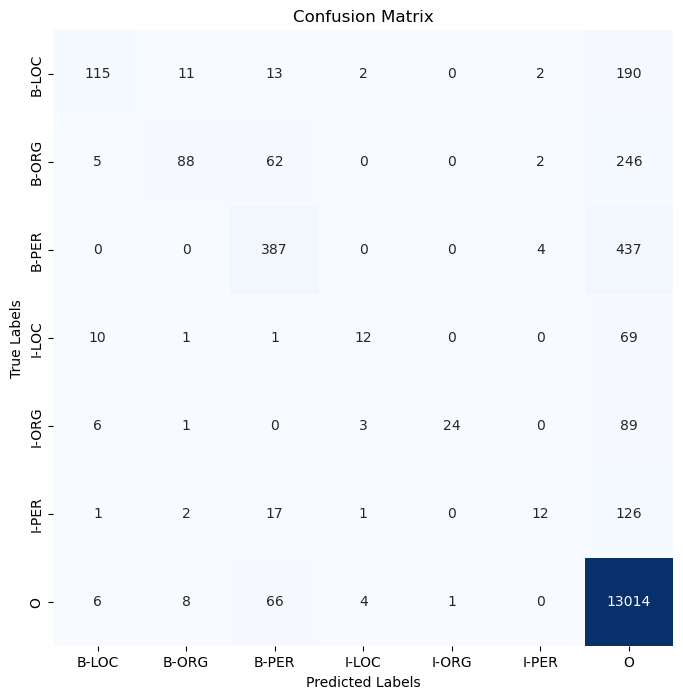

In [145]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report

/opt/homebrew/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=7)

df = pd.DataFrame([t for s in ner_data for t in s], columns=['Token', 'NER'])

X = df['Token'].tolist()
y = df['NER'].tolist()

label_map = {'B-LOC': 0, 'B-ORG': 1, 'B-PER': 2, 'I-LOC': 3, 'I-ORG': 4, 'I-PER': 5, 'O': 6}
y = [label_map[label] for label in y]

kf = KFold(n_splits=2, shuffle=True, random_state=42)

report = None

for train_index, test_index in kf.split(X):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = torch.tensor([y[i] for i in train_index]), torch.tensor([y[i] for i in test_index])

    encoding_train = tokenizer(X_train, truncation=True, padding=True, return_tensors='pt')
    encoding_test = tokenizer(X_test, truncation=True, padding=True, return_tensors='pt')

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    model.train()
    for epoch in range(3):
        optimizer.zero_grad()
        loss, _ = model(input_ids=encoding_train['input_ids'], 
                        token_type_ids=encoding_train['token_type_ids'],
                        attention_mask=encoding_train['attention_mask'], 
                        labels=y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(input_ids=encoding_test['input_ids'], 
                       token_type_ids=encoding_test['token_type_ids'], 
                       attention_mask=encoding_test['attention_mask'])[0].argmax(dim=1)
    report_curr = classification_report(y_test, y_pred, output_dict=True)

    if report is None:
        report = report_curr
    else:
        for key in report_curr.keys():
            if key != 'accuracy':
                report[key]['precision'] += report_curr[key]['precision']
                report[key]['recall'] += report_curr[key]['recall']
                report[key]['f1-score'] += report_curr[key]['f1-score']
        report['accuracy'] += report

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b